## Import Packages

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm

In [24]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
ROOT_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            name = os.path.join(ROOT_DIR, folder,file)
            labels[name] = folder
            
files = labels.keys()

## Load the Model and Compute Embeddings

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
transform = T.Compose([T.ToTensor(), T.Resize(224), T.CenterCrop(224), T.Normalize([0.5],[0.5])])

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [6]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    return transform(img)[:3].unsqueeze(0)

In [7]:
def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
        for i, file in enumerate(tqdm(files)):
            embeddings = dinov2_vits14(load_image(file).to(device))

            all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [8]:
embeddings = compute_embeddings(files)

  0%|          | 0/14034 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

SVC()

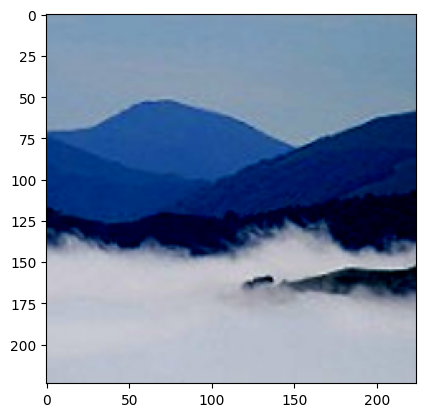

Image: 14986.jpg
Predicted class: mountain



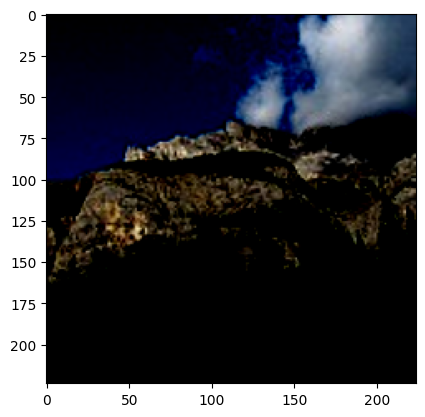

Image: 3138.jpg
Predicted class: mountain



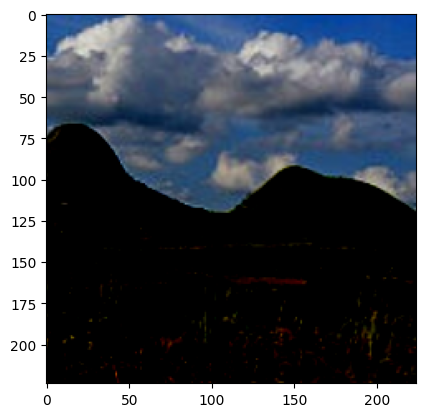

Image: 1700.jpg
Predicted class: mountain



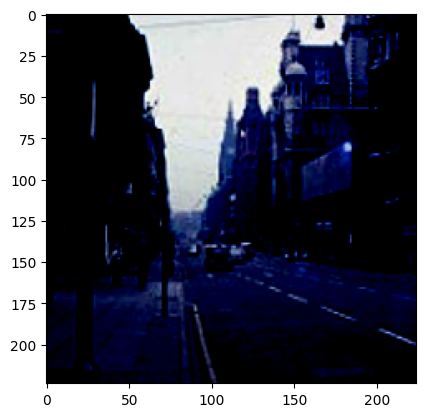

Image: 1269.jpg
Predicted class: street



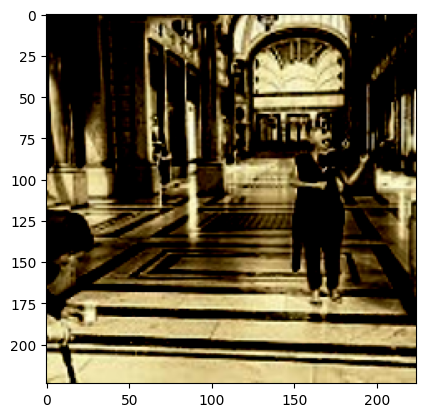

Image: 6241.jpg
Predicted class: street



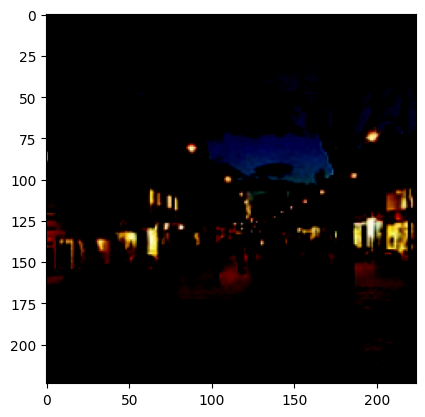

Image: 14143.jpg
Predicted class: street



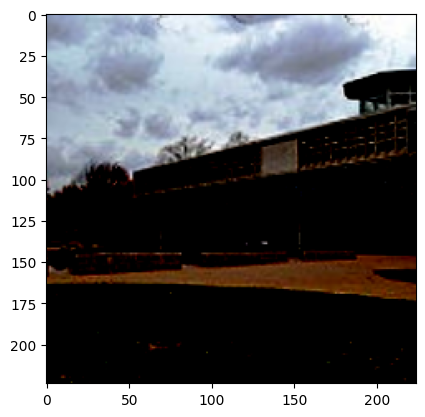

Image: 2193.jpg
Predicted class: buildings



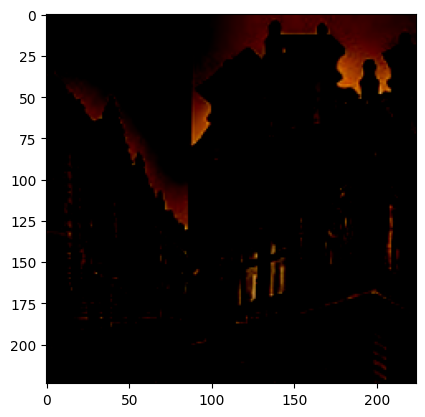

Image: 11378.jpg
Predicted class: buildings



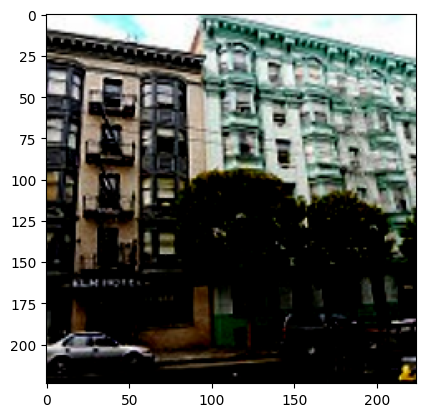

Image: 10730.jpg
Predicted class: buildings



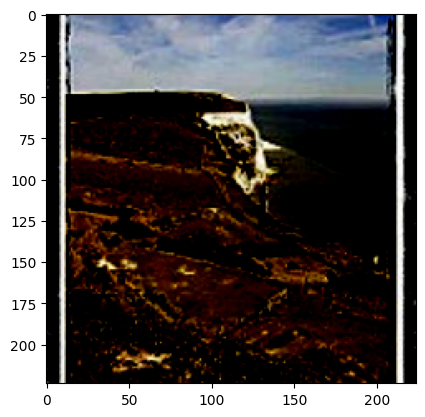

Image: 19812.jpg
Predicted class: sea



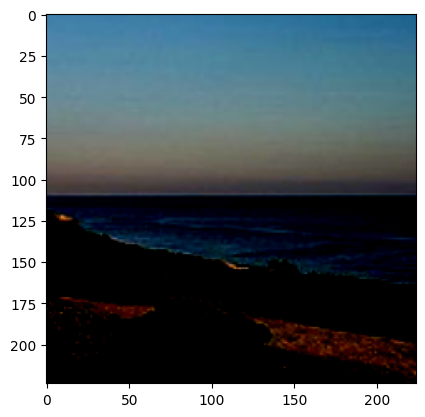

Image: 16916.jpg
Predicted class: sea



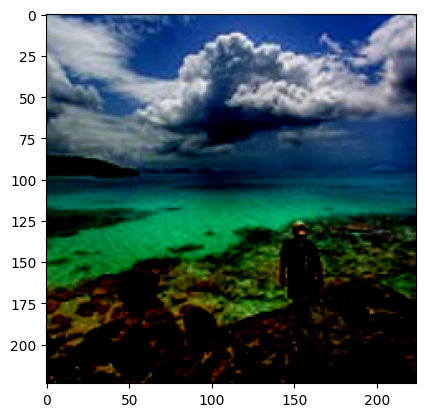

Image: 10304.jpg
Predicted class: sea



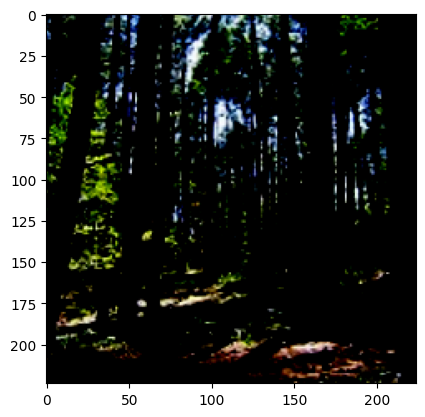

Image: 7981.jpg
Predicted class: forest



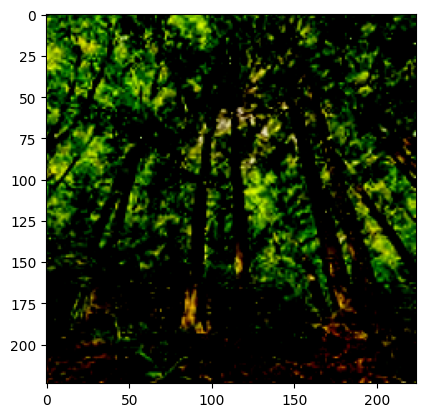

Image: 3863.jpg
Predicted class: forest



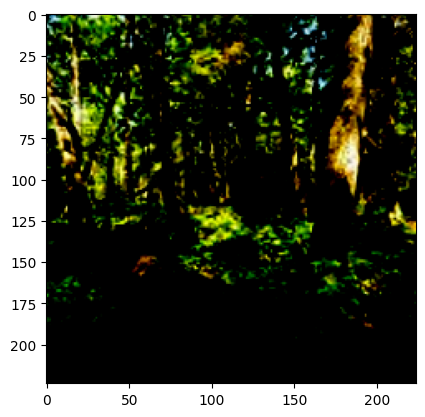

Image: 11925.jpg
Predicted class: forest



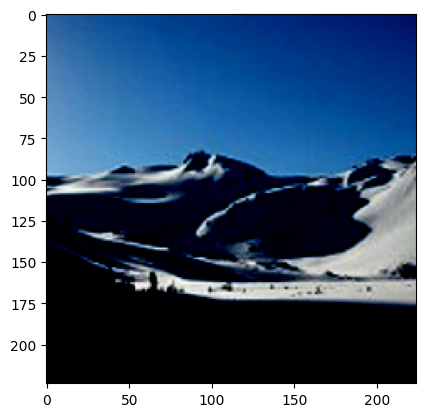

Image: 12666.jpg
Predicted class: glacier



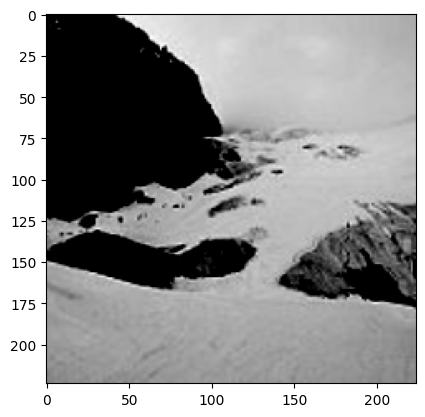

Image: 13288.jpg
Predicted class: glacier



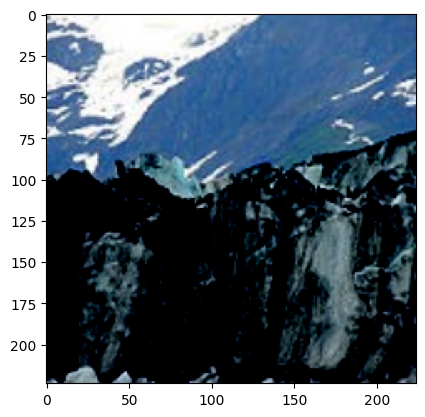

Image: 3750.jpg
Predicted class: glacier



In [25]:
import os
import matplotlib.pyplot as plt

input_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"

classes = os.listdir(input_dir)

for class_name in classes:
    class_dir = os.path.join(input_dir, class_name)
    image_files = os.listdir(class_dir)[:3]  
    for image_file in image_files:
        # Load the image
        image_path = os.path.join(class_dir, image_file)
        new_image = load_image(image_path)

        # Display the image
        plt.imshow(new_image[0].permute(1, 2, 0))
        plt.show()

        # Perform prediction
        with torch.no_grad():
            embedding = dinov2_vits14(new_image.to(device))
            prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

            # Print the predicted class
            print("Image:", image_file)
            print("Predicted class:", prediction[0])
            print()
